# 概况

本文档用于展示一种基于最小生成树进行选股并采用HRP算法生成权重的策略*的复现.

Cho, Y., & Song, J. W. (2023). Hierarchical risk parity using security selection based on peripheral assets of correlation-based minimum spanning trees. Finance Research Letters, 53, 103608. https://doi.org/10.1016/j.frl.2022.103608

作者: SiyuanLi, lisiyuanSven@foxmail.com

In [12]:
import framework_portfolio_weight_performace as portfolio_weight_performace
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import warnings
warnings.filterwarnings('ignore')

In [2]:
price_data = portfolio_weight_performace.readWindSP500()
return_data = price_data.pct_change().dropna()

instance0 = portfolio_weight_performace.CorrProcess(return_data)
FC_matrix , GMSC_matrix = instance0.FC_GMSC()

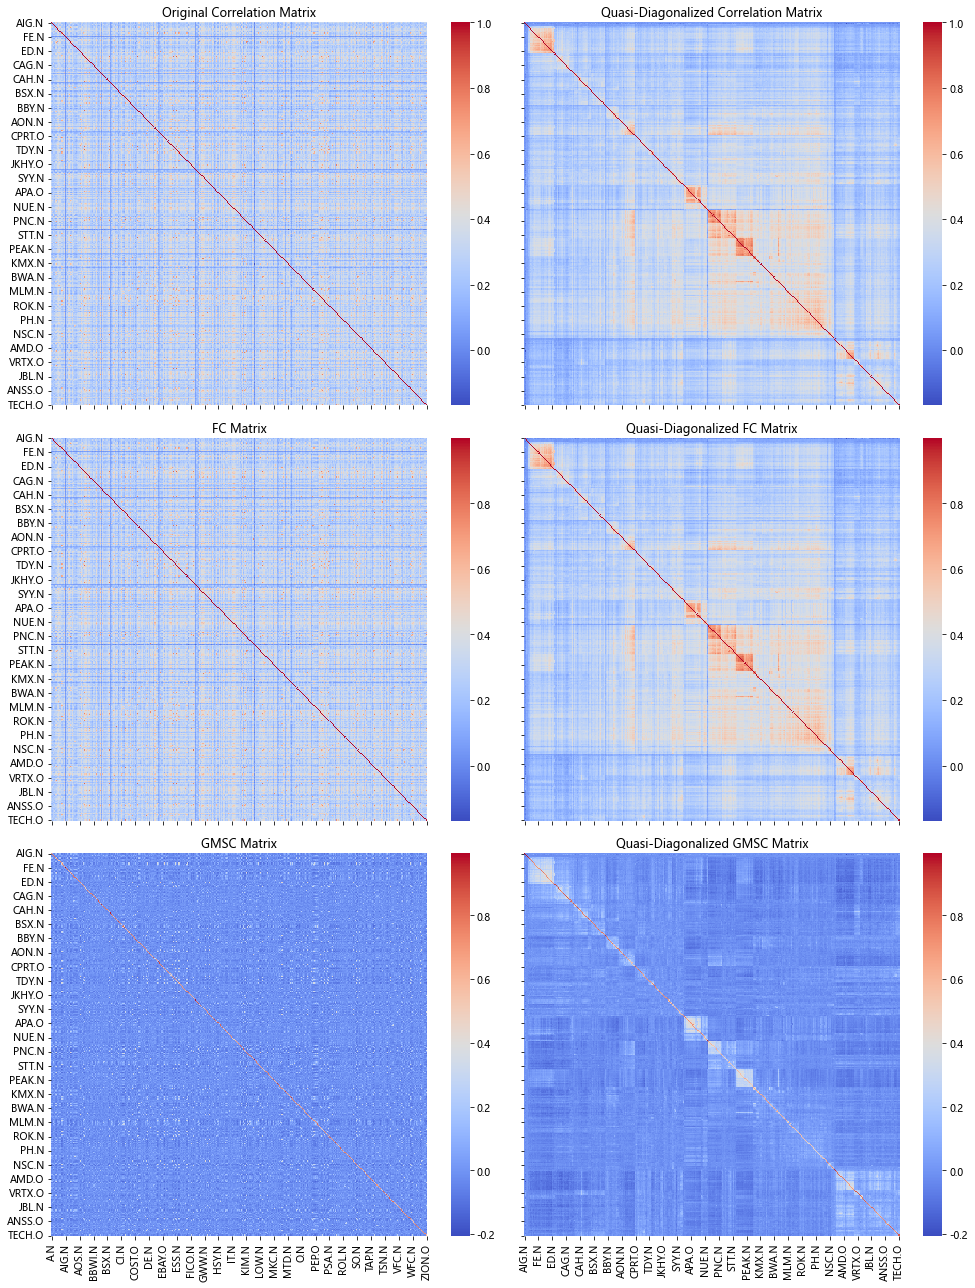

In [3]:
%matplotlib inline
instance0.show_corr_profile()

# 最小生成树(MST)选股

使用最小生成树的degree作为选股的依据, 是对原文的简化, 也是我们后面实际使用的方案. 

In [4]:
def draw_mst(matrix, k, ax, title):
    '''
    功能: 绘制FC矩阵的最小生成树. 标记最核心的一个资产, 和最边缘的k个资产.

    matrix: 处理过的相关系数矩阵, 如FC和GMSC
    ax: 绘图位置, plt对象
    title: 绘图标题
    k: 选择的最远的资产的数量
    '''

    # 计算距离矩阵
    distance_matrix = np.sqrt(2 * (1 - matrix.values))
    
    # 创建图
    G = nx.Graph()
    
    # 添加带有权重的边和节点标签
    for i in range(len(distance_matrix)):
        for j in range(i + 1, len(distance_matrix)):
            weight = np.round(distance_matrix[i][j], 4)
            G.add_edge(matrix.index[i], matrix.index[j], weight=weight)
    
    # 构建最小生成树
    mst = nx.minimum_spanning_tree(G)

    # 获取每个节点的度
    degrees = dict(mst.degree())

    # 找到度最高的节点（最紧密的节点）
    most_connected_node = max(degrees, key=degrees.get)

    # 按度排序节点，选择度最低的k个节点（最稀疏的节点）
    sparsest_nodes = sorted(degrees, key=degrees.get)[:k]

    # 使用Kamada-Kawai布局
    pos = nx.kamada_kawai_layout(mst)
    
    # 绘制所有节点
    nx.draw_networkx_nodes(mst, pos, node_color='lightgrey', node_size=400, ax=ax)
    
    # 突出显示中心节点
    nx.draw_networkx_nodes(mst, pos, nodelist=[most_connected_node], node_color='red', node_size=600, ax=ax)
    
    # 突出显示边缘节点
    nx.draw_networkx_nodes(mst, pos, nodelist=sparsest_nodes, node_color='green', node_size=600, ax=ax)
    
    # 绘制边
    nx.draw_networkx_edges(mst, pos, width=2, ax=ax, edge_color='black')
    
    # 节点标签
    nx.draw_networkx_labels(mst, pos, ax=ax)

    ax.set_title(title)
    ax.axis('off')  # 关闭坐标轴

    return sparsest_nodes

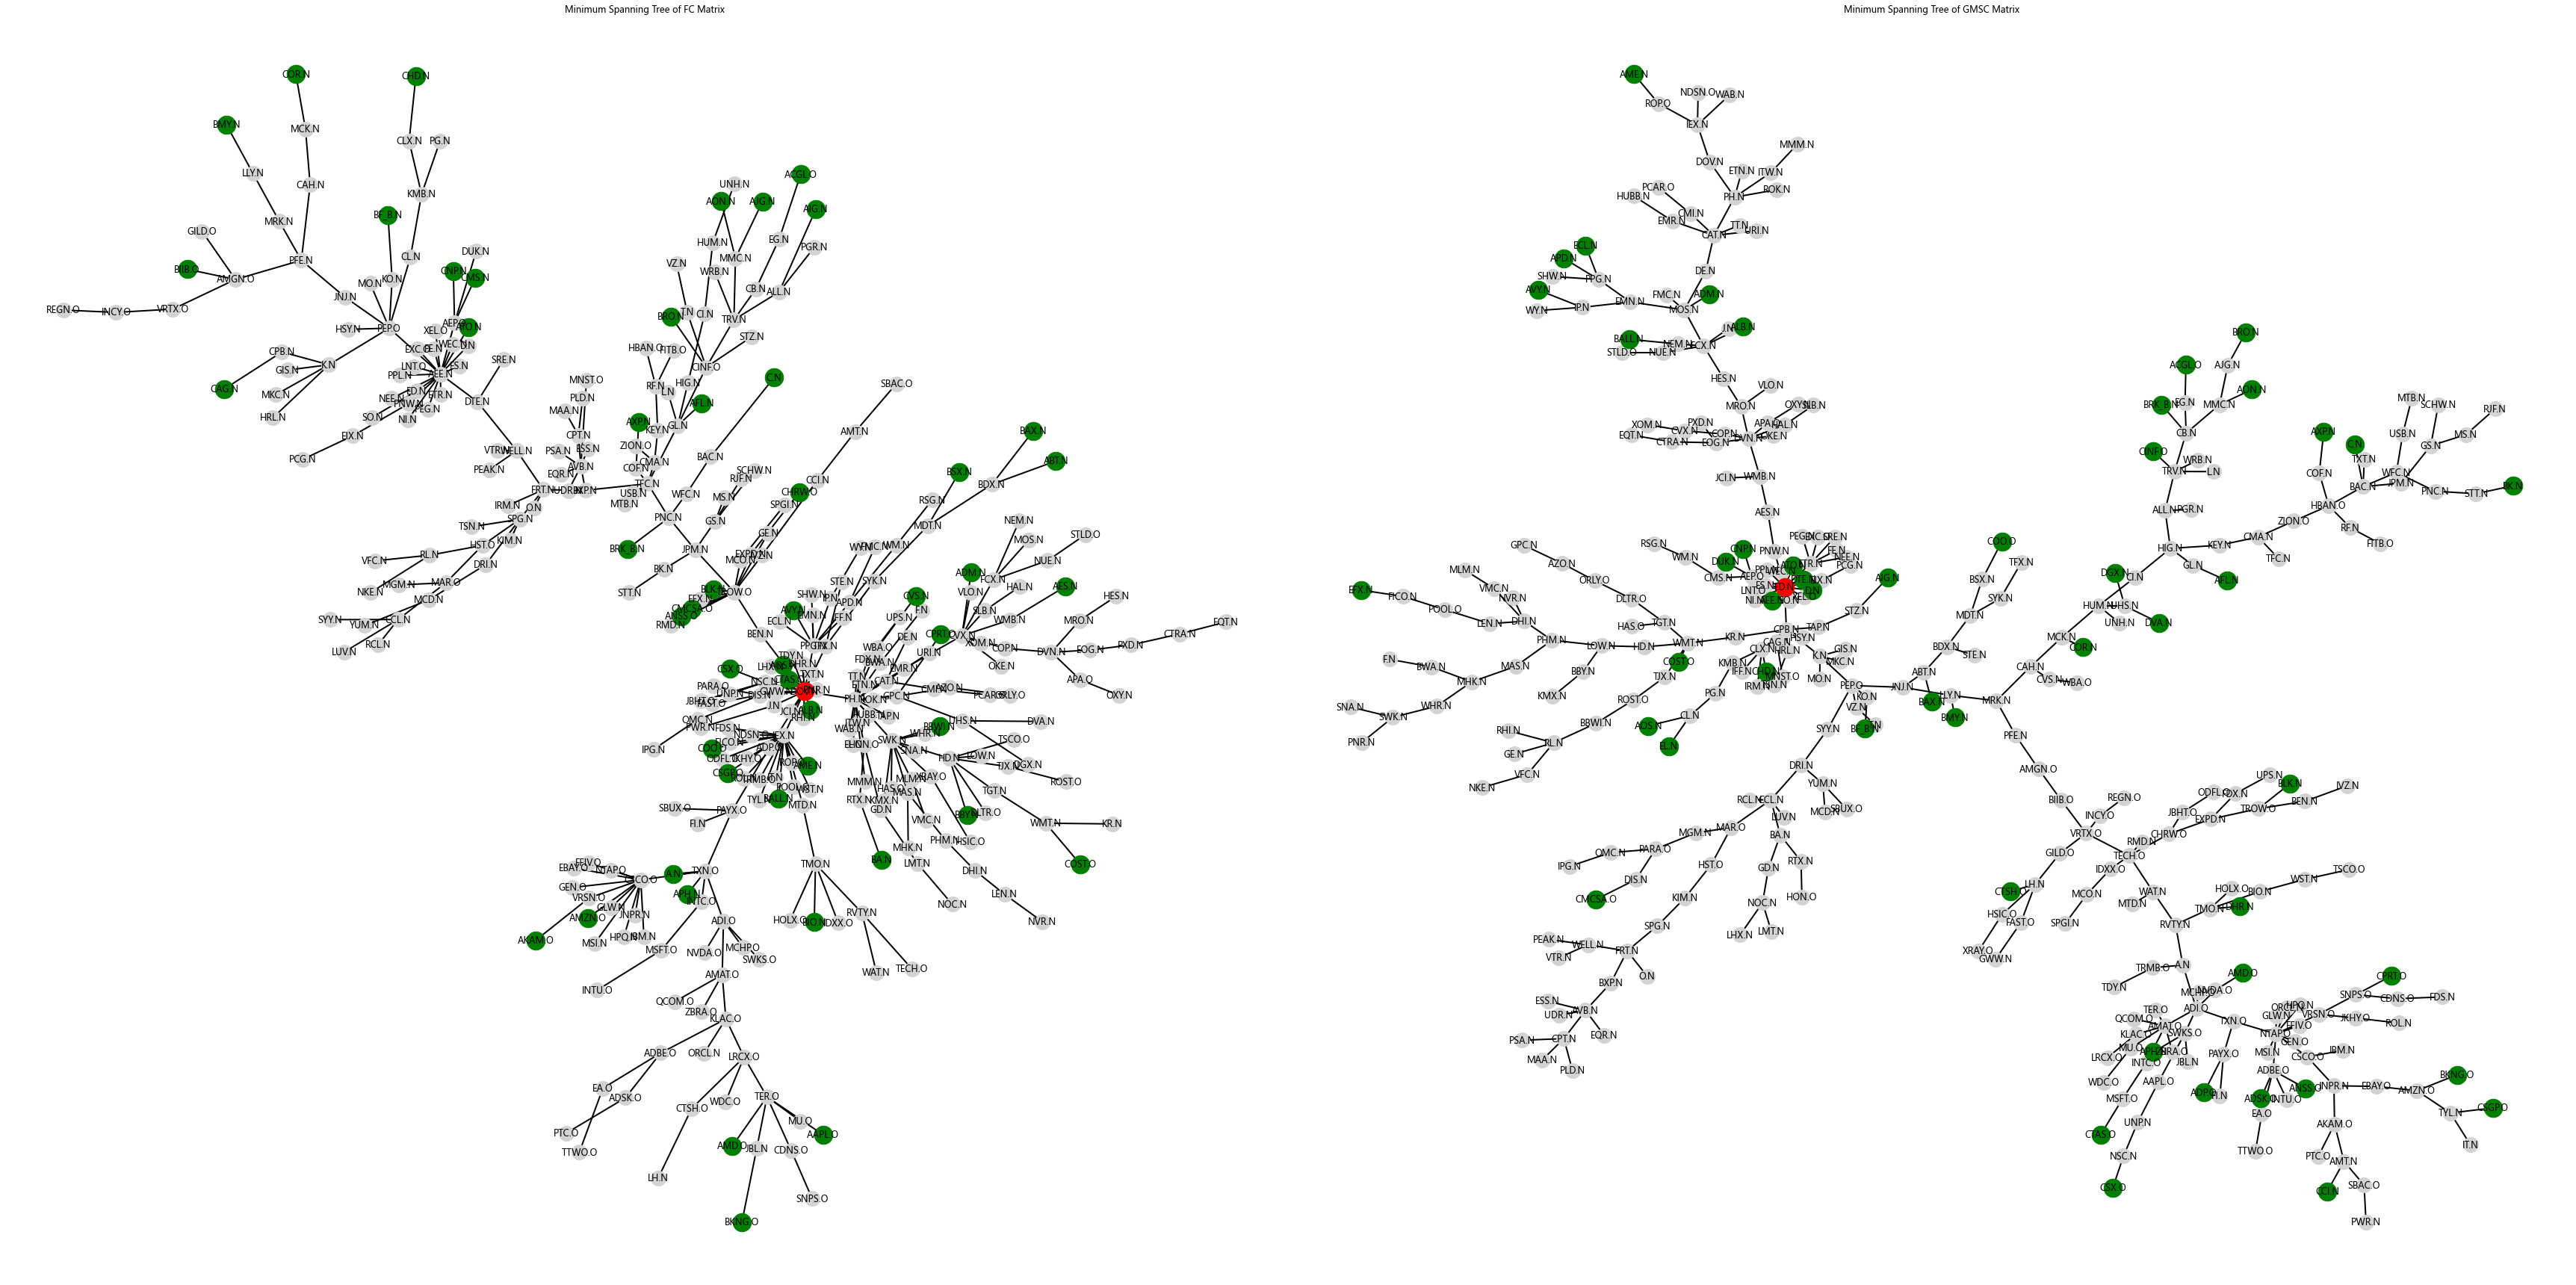

In [5]:
%matplotlib inline
# 准备画布和子图
fig, axes = plt.subplots(1, 2, figsize=(48, 24))  # 调整画布大小
# 设置画布背景为白色
fig.patch.set_facecolor('white')

# 假设FC_matrix和GMSC_matrix是已经计算好的矩阵
# 以下代码为示例，实际使用时应替换为具体的矩阵
sparsest_nodes_FC = draw_mst(matrix=FC_matrix, k=50, ax=axes[0], title='Minimum Spanning Tree of FC Matrix')
sparsest_nodes_GMSC = draw_mst(matrix=GMSC_matrix, k=50, ax=axes[1], title='Minimum Spanning Tree of GMSC Matrix')

plt.tight_layout()
plt.show()

# 混合测度MST选股

对原文的精准复刻的尝试, 但由于混合测度中部分参数不能确认, 实际得到的结果与文中展示的差距较大, 故弃用. 

In [6]:
from tqdm import tqdm

def weighted_degree_centrality(G):
    """
    计算加权度中心性（强度）。
    每个节点的加权度中心性是其所有邻接边的权重和, 每个权重加1。
    
    参数:
    G: 一个NetworkX图对象, 其边具有'weight'属性表示权重。

    返回:
    dict: 每个节点的加权度中心性（强度）。
    """
    centrality = {}
    for node in G.nodes():
        node_weight = sum((G[u][v]['weight'] + 1) for u, v in G.edges(node))
        centrality[node] = node_weight
    return centrality


def draw_mst_mixed(matrix, k, ax, title, if_draw=True):
    '''
    功能: 绘制FC矩阵的最小生成树. 标记最核心的一个资产, 和最边缘的k个资产.

    matrix: 处理过的相关系数矩阵, 如FC和GMSC
    ax: 绘图位置, plt对象
    title: 绘图标题
    k: 选择的最远的资产的数量
    '''

    # Calculate distance matrix
    distance_matrix = np.sqrt(2 * (1 - matrix.values))
    
    # Create the graph
    G = nx.Graph()

    # Add weighted edges
    for i in range(len(distance_matrix)):
        for j in range(i + 1, len(distance_matrix)):
            weight = np.round(distance_matrix[i][j], 4)
            G.add_edge(matrix.index[i], matrix.index[j], weight=weight)

    # Build the minimum spanning tree
    mst = nx.minimum_spanning_tree(G)

    # Calculate all pairs shortest path lengths for weighted and unweighted scenarios
    sp_weighted = {node: nx.single_source_dijkstra_path_length(mst, source=node, weight='weight') for node in mst.nodes()}
    sp_unweighted = {node: nx.single_source_dijkstra_path_length(mst, source=node) for node in mst.nodes()}

    # Calculate eccentricities using the shortest path lengths
    eccentricity_w = {node: nx.eccentricity(mst, v=node, sp=sp_weighted) for node in mst.nodes()}
    eccentricity_uw = {node: nx.eccentricity(mst, v=node, sp=sp_unweighted) for node in mst.nodes()}

    # Precompute centrality measures for all nodes
    degree_centrality = nx.degree_centrality(mst)
    degree_centrality_w = weighted_degree_centrality(mst)
    betweenness_centrality_w = nx.betweenness_centrality(mst, weight='weight')
    betweenness_centrality_uw = nx.betweenness_centrality(mst)
    closeness_centrality_w = nx.closeness_centrality(mst, distance='weight')
    closeness_centrality_uw = nx.closeness_centrality(mst)
    eigenvector_centrality_w = nx.eigenvector_centrality(mst, weight='weight')
    eigenvector_centrality_uw = nx.eigenvector_centrality(mst)

    N = mst.number_of_nodes()
    node_scores = {}
    for node in tqdm(mst.nodes()):
        # Retrieve precomputed centrality values
        R_D_w = degree_centrality[node]  # Degree centrality, treated as weighted
        R_D_uw = degree_centrality_w[node]  # Degree centrality, treated as unweighted
        R_BC_w = betweenness_centrality_w[node]  # Betweenness centrality, weighted
        R_BC_uw = betweenness_centrality_uw[node]  # Betweenness centrality, unweighted
        R_C_w = closeness_centrality_w[node]  # Closeness centrality, weighted
        R_C_uw = closeness_centrality_uw[node]  # Closeness centrality, unweighted
        R_E_w = eccentricity_w[node]  # Eccentricity, weighted
        R_E_uw = eccentricity_uw[node]  # Eccentricity, unweighted
        R_EC_w = eigenvector_centrality_w[node]  # Eigenvector centrality, weighted
        R_EC_uw = eigenvector_centrality_uw[node]  # Eigenvector centrality, unweighted

        # Explicit formulas for X and Y
        X = (R_D_w + R_D_uw + R_BC_w + R_BC_uw - 4) / 4 * (N - 1)
        Y = (R_E_w + R_E_uw + R_C_w + R_C_uw + R_EC_w + R_EC_uw - 6) / 6 * (N - 1)

        # Compute the final score for each node
        node_scores[node] = X + Y

    # Identify the most central and peripheral nodes
    sorted_nodes = sorted(node_scores, key=node_scores.get)
    most_central_node = sorted_nodes[0]
    most_peripheral_nodes = sorted_nodes[-k:]

    if if_draw:

        # 使用Kamada-Kawai布局
        pos = nx.kamada_kawai_layout(mst)
        
        # 绘制所有节点
        nx.draw_networkx_nodes(mst, pos, node_color='lightgrey', node_size=400, ax=ax)
        
        # 突出显示中心节点
        nx.draw_networkx_nodes(mst, pos, nodelist=[most_central_node], node_color='red', node_size=600, ax=ax)
        
        # 突出显示边缘节点
        nx.draw_networkx_nodes(mst, pos, nodelist=most_peripheral_nodes, node_color='green', node_size=600, ax=ax)
        
        # 绘制边
        nx.draw_networkx_edges(mst, pos, width=2, ax=ax, edge_color='black')
        
        # 节点标签
        nx.draw_networkx_labels(mst, pos, ax=ax)

        ax.set_title(title)
        ax.axis('off')  # 关闭坐标轴

    return most_central_node, sorted_nodes

FC_matrix started


100%|██████████| 352/352 [00:00<00:00, 352277.50it/s]


GMSC_matrix started


100%|██████████| 352/352 [00:00<00:00, 352025.51it/s]


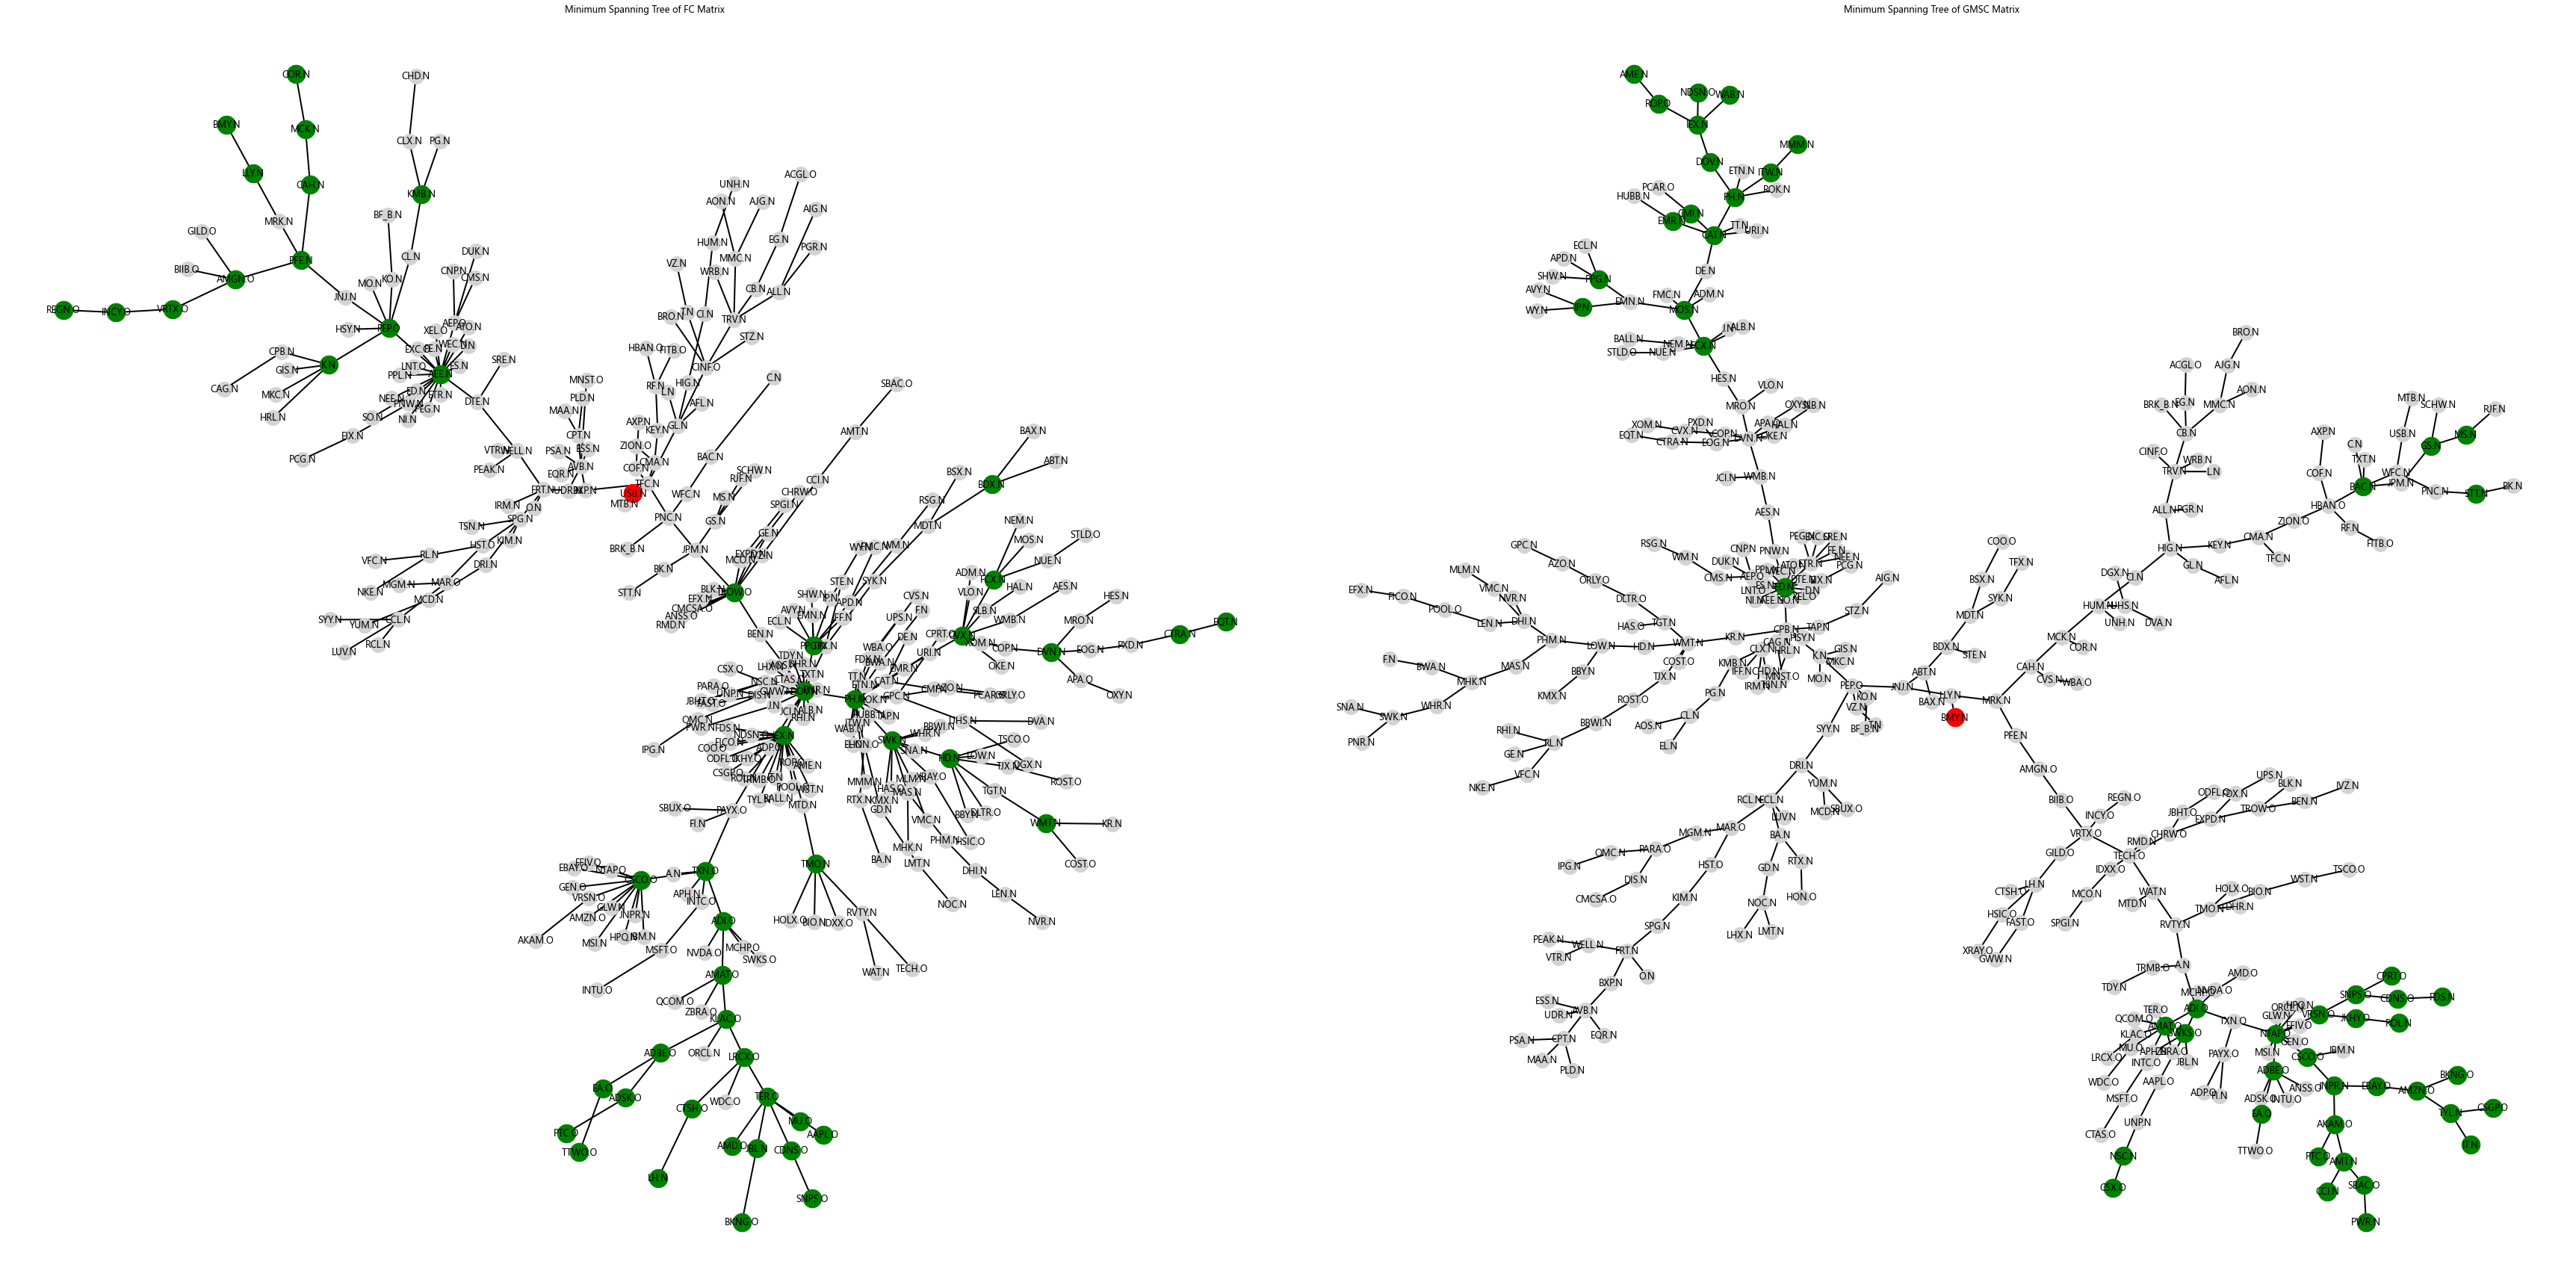

In [7]:
%matplotlib inline
# 准备画布和子图
fig, axes = plt.subplots(1, 2, figsize=(48, 24))  # 调整画布大小
# 设置画布背景为白色
fig.patch.set_facecolor('white')

# 假设FC_matrix和GMSC_matrix是已经计算好的矩阵
# 以下代码为示例，实际使用时应替换为具体的矩阵
print('FC_matrix started')
_, sparsest_nodes_FC = draw_mst_mixed(matrix=FC_matrix, k=50, ax=axes[0], title='Minimum Spanning Tree of FC Matrix')
print('GMSC_matrix started')
_, sparsest_nodes_GMSC = draw_mst_mixed(matrix=GMSC_matrix, k=50, ax=axes[1], title='Minimum Spanning Tree of GMSC Matrix')

plt.tight_layout()
plt.show()

# 基于HRP的回测

In [ ]:
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

## 回测过程

因为ipynb不方便实现多进程, 所以此处比较慢(30min左右). 

In [8]:
sparsest_nodes_FC = draw_mst(matrix=FC_matrix, k=50, ax=axes[0], title='Minimum Spanning Tree of FC Matrix')
sparsest_nodes_GMSC = draw_mst(matrix=GMSC_matrix, k=50, ax=axes[1], title='Minimum Spanning Tree of GMSC Matrix')

selected_price_data_GMSC = price_data[sparsest_nodes_GMSC]
selected_price_data_FC = price_data[sparsest_nodes_FC]

此文件只是demo, 测试mst选股以及HRP回测的可行性. 

没有每日重新选股, 而是只在最开始的120日数据进行了一次选股, 持有到最后

In [13]:
w = 120
k = 50

"""回测"""
window_size = int(w)    # 窗口大小

lis_weights_IV = []
lis_weights_HRP = []
lis_weights_HRP_FC = []
lis_weights_HRP_GMSC = []

lis_test_date = []


count = 0
# 迭代DataFrame，创建每个实验期的切片
for start_day in tqdm(range(len(selected_price_data_GMSC) - window_size - 1)):

    end_train_day = start_day + window_size

    # 实验期的切片
    experiment_slice = selected_price_data_GMSC.iloc[start_day:end_train_day]
    
    # 测试期的切片, 从实验期开始后250天开始. 前250天仅用来估计参数了
    test_date = end_train_day + 1
    lis_test_date.append(selected_price_data_GMSC.index[test_date])
    returns_train = experiment_slice.pct_change().dropna()

    # HRP
    HRP_instance = portfolio_weight_performace.GenPortfolioWeight(returns_train, shrinkage=False)
    weights_HRP = HRP_instance.genHRPweights()
    lis_weights_HRP.append(weights_HRP)

    # HRP-FC 此处省略
    instance0 = portfolio_weight_performace.CorrProcess(returns_train)
    FC_matrix , GMSC_matrix = instance0.FC_GMSC()
    
    '''HRP_FC = portfolio_weight_performace.GenPortfolioWeight(returns_train, special_corr=FC_matrix, shrinkage=False)
    weights_FC = HRP_FC.genHRPweights()
    '''

    # HRP GMSC
    HRP_GMSC = portfolio_weight_performace.GenPortfolioWeight(returns_train, special_corr=GMSC_matrix, shrinkage=False)
    weights_GMSC = HRP_GMSC.genHRPweightsSpecialCorr()
    lis_weights_HRP_GMSC.append(weights_GMSC)
 
    # Inverse Volatility
    experiment_window = portfolio_weight_performace.GenPortfolioWeight(experiment_slice) # 计算IV要收缩估计, 输入为价格数据而非收益率
    weights = experiment_window.genIVweights()
    lis_weights_IV.append(weights.to_dict())

100%|██████████| 5695/5695 [32:04<00:00,  2.96it/s]


In [14]:
lis_weights_ND = []
for series in lis_weights_HRP_GMSC:
    count = len(series)
    equal_weight = 1 / count
    # 创建一个新的Series，索引与原Series相同，每个元素的值都是等权重
    equal_weight_series = pd.Series(equal_weight, index=series.index)
    lis_weights_ND.append(equal_weight_series)

## 回测表现

回测时, 使用for循环计算每日收益率. 这个做法很慢, 但可以精确计算摩擦成本(手续费\印花税)的影响.

In [39]:
'''%load_ext autoreload
%autoreload 1
%aimport framework_portfolio_weight_performace'''
# 调试用
import framework_portfolio_weight_performace as portfolio_weight_performace

portfolio_IV generated
portfolio_HRP_GMSC generated
portfolio_HRP generated
portfolio_ND generated
调用PortfolioPerformance对象获得数据


HRP_GMSC        ND
annual_std             0.168397  0.208066
annual_return          0.097807  0.130605
sharpe_ratio           0.402662  0.483523
average_turnover_rate  0.142066  0.017614
var_5                 -0.015065 -0.018031
cvar_5                -0.024560 -0.028727
max_drawdown          -0.438226 -0.518945
calmar_ratio           0.223189  0.251673
sortino_ratio          0.510295  0.656694

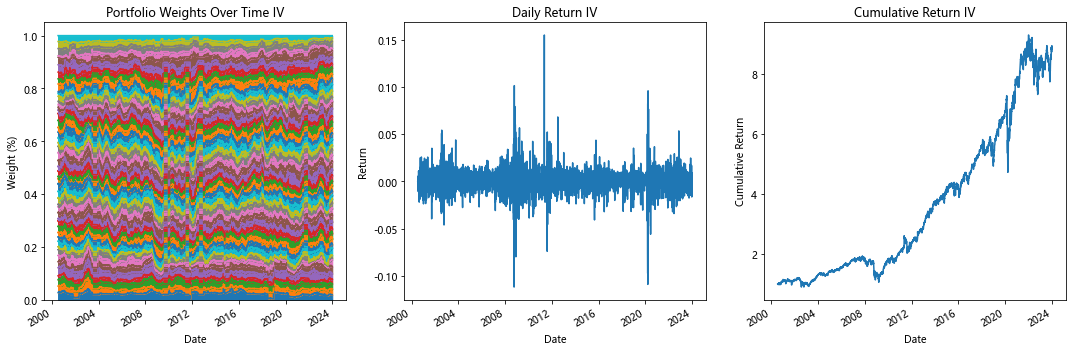

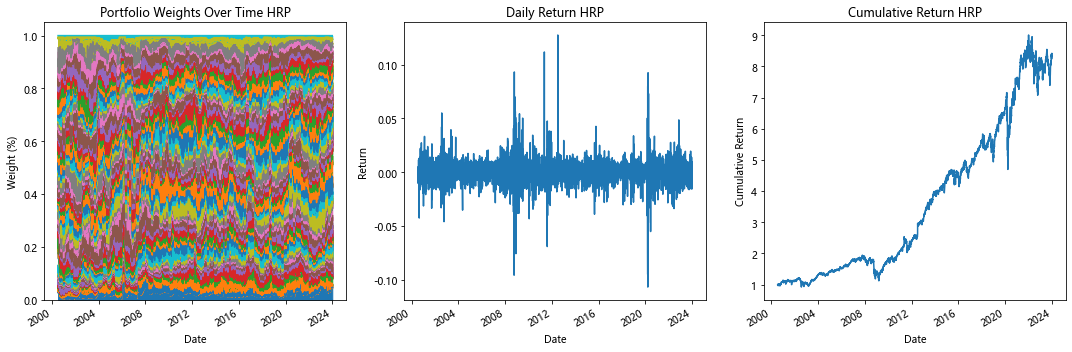

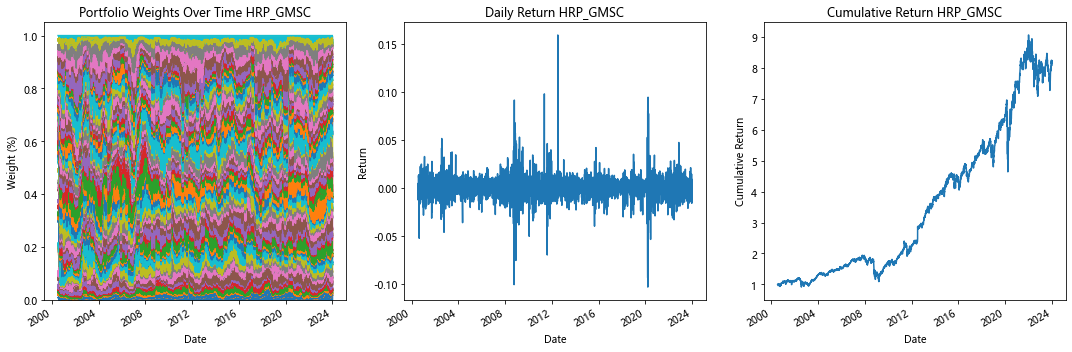

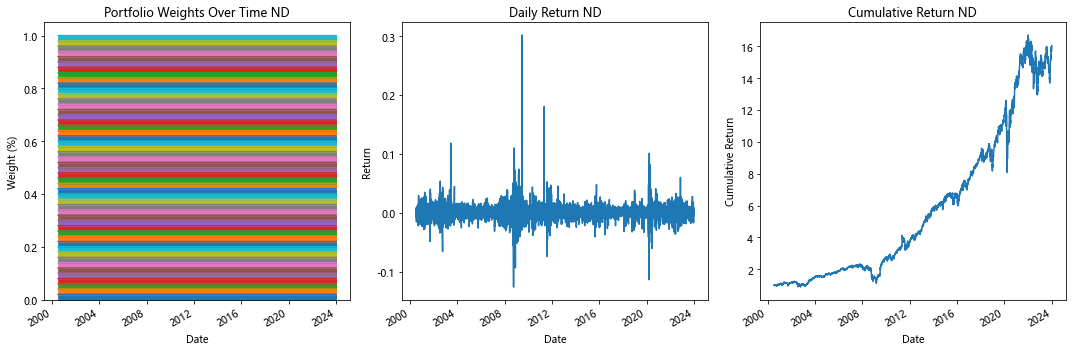

In [40]:
'''%load_ext autoreload
%autoreload 1
%aimport framework_portfolio_weight_performace'''


# 生成PortfolioPerformance对象
portfolio_HRP = portfolio_weight_performace.PortfolioPerformance(lis_weights = lis_weights_HRP,
                                                price_df=price_data,
                                                lis_test_date=lis_test_date,
                                                title='HRP')

portfolio_IV = portfolio_weight_performace.PortfolioPerformance(lis_weights = lis_weights_IV,
                                                        price_df=selected_price_data_GMSC,
                                                        lis_test_date=lis_test_date,
                                                        title='IV')
print('portfolio_IV generated')
portfolio_HRP_GMSC = portfolio_weight_performace.PortfolioPerformance(lis_weights = lis_weights_HRP_GMSC,
                                                        price_df=selected_price_data_GMSC,
                                                        lis_test_date=lis_test_date,
                                                        title='HRP_GMSC')
print('portfolio_HRP_GMSC generated')
portfolio_HRP = portfolio_weight_performace.PortfolioPerformance(lis_weights = lis_weights_HRP,
                                                        price_df=selected_price_data_GMSC,
                                                        lis_test_date=lis_test_date,
                                                        title='HRP')
print('portfolio_HRP generated')
portfolio_ND = portfolio_weight_performace.PortfolioPerformance(lis_weights = lis_weights_ND,
                                                        price_df=selected_price_data_GMSC,
                                                        lis_test_date=lis_test_date,
                                                        title='ND')
print('portfolio_ND generated')

# 调用PortfolioPerformance对象获得数据
print('调用PortfolioPerformance对象获得数据')
# weight_df_HRP, daily_return_HRP, cumulative_return_HRP = portfolio_HRP.plot_charts(if_show_pic=False) 
weight_df_IV, daily_return_IV, cumulative_return_IV = portfolio_IV.plot_charts()
weight_df_HRP, daily_return_HRP, cumulative_return_HRP = portfolio_HRP.plot_charts()
weight_df_HRP_GMSC, daily_return_HRP_GMSC, cumulative_return_HRP_GMSC = portfolio_HRP_GMSC.plot_charts() 
weight_df_ND, daily_return_ND, cumulative_return_ND = portfolio_ND.plot_charts() 

performance_df = portfolio_weight_performace.aggregate_performances(portfolio_HRP_GMSC, portfolio_ND)
performance_df

In [41]:
SP500_df = pd.read_excel(r'..\WashedData\SP500indexFromWind.xlsx', index_col=0, header=0)
cumulative_return_SP500 = (1 + SP500_df.pct_change().dropna()).cumprod()

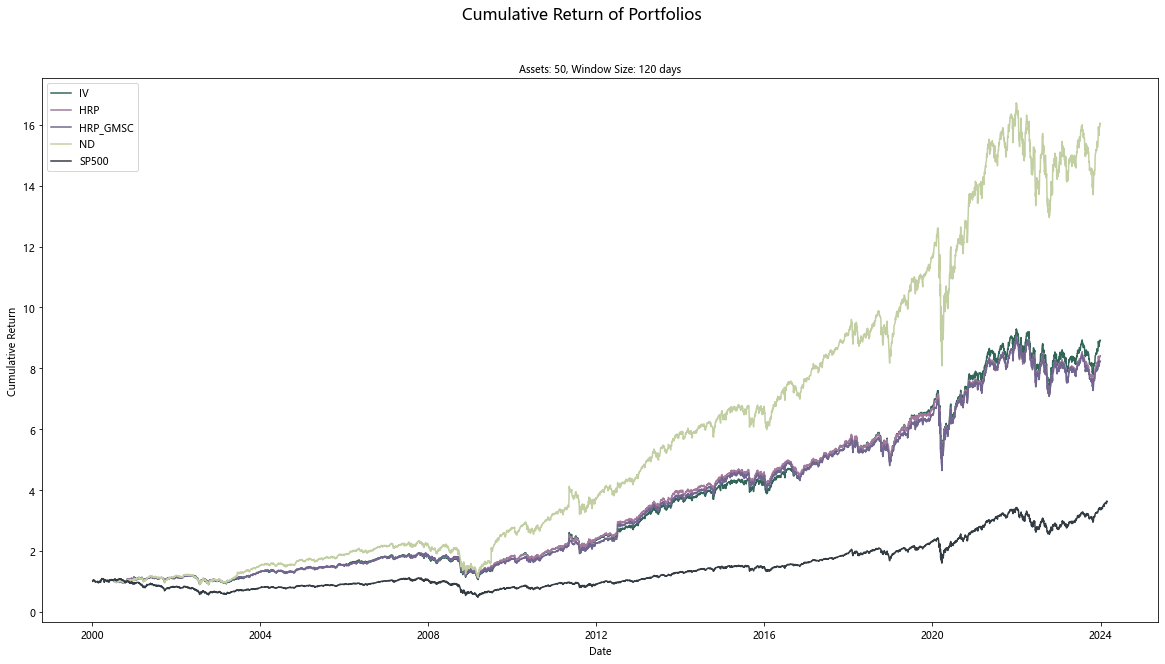

In [42]:
# 保存累计收益率图表
plt.figure(figsize=(20, 10))

# 指定颜色
colors = {
    'HRP_GMSC': '#70668f',    # 
    'HRP': '#a3799c',    # 
    'IV': '#326658',  # 
    'HRP_FC': '#5da59b',  # 
    'SP500': '#333b43', # 
    'ND': '#c2cfa3',        # 
}

# 绘制累计回报率曲线

plt.plot(cumulative_return_IV, label='IV', color=colors['IV'])
plt.plot(cumulative_return_HRP, label='HRP', color=colors['HRP'])
plt.plot(cumulative_return_HRP_GMSC, label='HRP_GMSC', color=colors['HRP_GMSC'])
plt.plot(cumulative_return_ND, label='ND', color=colors['ND'])
plt.plot(cumulative_return_SP500, label='SP500', color=colors['SP500'])

# 设置主标题和副标题
plt.suptitle('Cumulative Return of Portfolios', fontsize=16)
plt.title(f'Assets: {k}, Window Size: {window_size} days', fontsize=10)

# 设置轴标签和图例
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.legend()
# plt.grid(True)
plt.show()